In [13]:
import pandas as pd
import numpy as np
import maddpkg
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load train and test sets

X_train = pd.read_csv("./data_courseBBB/X_train_stClick_7030.csv")
X_test = pd.read_csv("./data_courseBBB/X_test_stClick_7030.csv")
y_train = pd.read_csv("./data_courseBBB/y_train_stClick_7030.csv").values.ravel()
y_test = pd.read_csv("./data_courseBBB/y_test_stClick_7030.csv").values.ravel()

In [4]:
X_train.shape[0] + X_test.shape[0]

5299

In [5]:
# Learn a classifier

model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [6]:
NB_FOLD = 5
scores_train = cross_val_score(model, X_train, y_train, cv=NB_FOLD)
print("Accuracy on the train set with cross-validation: \n - %0.2f with a standard deviation of %0.2f" % (scores_train.mean(), scores_train.std()))
print(f"Accuracy on the test set: \n - {round(accuracy_score(y_test, model.predict(X_test)), 2)}")

Accuracy on the train set with cross-validation: 
 - 0.72 with a standard deviation of 0.01
Accuracy on the test set: 
 - 0.72


In [7]:
# Predicted probabilities of positive predictions

y_pp_1 = model.predict_proba(X_test)[:, 1] 
y_pp_0 = model.predict_proba(X_test)[:, 0] 

In [8]:
sensitive_feature = "poverty"

In [9]:
y_pp_1 = y_pp_1[X_test[sensitive_feature] == 1]
y_pp_0 = y_pp_0[X_test[sensitive_feature] == 0]

In [14]:
def madd_plot(pred_proba_sf0, pred_proba_sf1, sf, e, model_name):
    """Plots a visual approximation of the MADD.

    Parameters
    ----------
    pred_proba_sf0 : np.ndarray of shape (n, 1)
        The predicted probabilities of positive predictions for group 0
    pred_proba_sf1 : np.ndarray of shape (n, 1)
        The predicted probabilities of positive predictions for group 1
    sf: str
        The name of the binary sensitive feature
    e: float
        The probability sampling parameter
    model_name: str
        The name of the model that outputs the predicted probabilities
    
    Returns
    -------
    Axes
        The Axes of the subplot

    """

    nb_bins = int(np.floor(1/e))

    # Arbitrary choices of colors
    if sf == "gender":
        color_gp1 = "mediumaquamarine"
        color_gp0 = "lightcoral"
    elif sf == "imd_band" or sf == "poverty":
        color_gp1 = "gold"
        color_gp0 = "dimgray"
    elif sf == "disability":
        color_gp1 = "mediumpurple"
        color_gp0 = "lightskyblue"
    elif sf == "age_band" or sf == "age":
        color_gp1 = "salmon"
        color_gp0 = "seagreen"
    else:  # random colors
        color_gp1 = (np.random.random(), np.random.random(), np.random.random())
        color_gp0 = (np.random.random(), np.random.random(), np.random.random())

    fig, axes = plt.subplots(1, 3, figsize=(10, 2.5), constrained_layout=True)  # figsize=(12, 4) for better visualization
    fig.supxlabel("Predicted probabilities  [0 ; 1]", fontsize=16, fontweight='bold')

    # plot D_G0
    ax0 = sns.histplot(ax=axes[0], data=pred_proba_sf1, kde=False, stat="proportion", color=color_gp1, bins=np.linspace(0,1,nb_bins))
    ax0.set_xlim(0, 1)
    ax0.set_ylabel("Proportion", fontsize=16, fontweight='bold')

    # plot D_G1
    ax1 = sns.histplot(ax=axes[1], data=pred_proba_sf0, kde=False, stat="proportion", color=color_gp0, bins=np.linspace(0,1,nb_bins))
    ax1.set_xlim(0, 1)
    ax1.set_yticklabels([]) # turn off y ticks labels
    ax1.yaxis.set_visible(False)

    # plot the density estimates
    ax2 = sns.kdeplot(ax=axes[2], data=pred_proba_sf1, color=color_gp1, label=sf + ": 1")
    ax2 = sns.kdeplot(ax=axes[2], data=pred_proba_sf0, color=color_gp0, label=sf + ": 0")
    ax2.set_ylabel("Density", fontsize=16, fontweight='bold')
    ax2.set_xlim(0, 1)
    
    plt.legend(bbox_to_anchor = (1.65, 0.5), loc='center right', prop={'weight':'bold'})
    ax1.set_title(f"{model_name}", loc="center", fontsize=16, fontweight='bold')


/Users/melinaverger/Desktop/MADD/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/melinaverger/Desktop/MADD/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/melinaverger/Desktop/MADD/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/melinaverger/Desktop/MADD/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

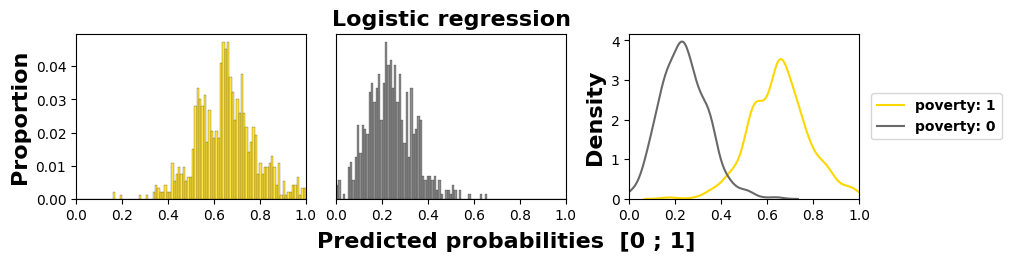

In [15]:
madd_plot(y_pp_0, y_pp_1, sensitive_feature, 0.01, "Logistic regression")

In [9]:
y_pp = np.array(
    pd.concat([pd.DataFrame(y_pp_0).set_index(X_test[X_test[sensitive_feature] == 0].index),
         pd.DataFrame(y_pp_1).set_index(X_test[X_test[sensitive_feature] == 1].index)],
         axis=0, ignore_index=False).sort_index()
)

## MADD(e)

In [10]:
e = np.linspace(start=0.0001, stop=1, num=10000, endpoint=False)

In [11]:
madd = [maddpkg.MADD(X_test, y_pp, sensitive_feature, ei) for ei in e]

In [12]:
madd_min_ind = np.argmin(madd)
print("MADD minimum:", madd[madd_min_ind])
print("e associated:", e[madd_min_ind])

MADD minimum: 0.0
e associated: 0.50005


In [13]:
#plt.plot(e, madd)
#plt.plot(e[madd_min_ind], madd[madd_min_ind], "o", label="MADD minimum")
#plt.xlabel("e")
#plt.ylabel("MADD")
#plt.title("MADD(e) with real-data (OULAD course BBB, logistic classifier, " + sensitive_feature + ")")

## MADD(e) focus on [0, 1]*optimal order

In [14]:
n0 = len(X_test[X_test[sensitive_feature] == 0])
n1 = len(X_test[X_test[sensitive_feature] == 1])
order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
print(n0)
print(n1)
print(order)

662
928
0.17257716851605825


In [15]:
e = np.linspace(start=0.0001, stop=order, num=10000, endpoint=False)

In [16]:
madd = [maddpkg.MADD(X_test, y_pp, sensitive_feature, ei) for ei in e]

In [17]:
madd_min_ind = np.argmin(madd)
print("MADD minimum:", madd[madd_min_ind])
print("e associated:", e[madd_min_ind])

MADD minimum: 1.7801333472236691
e associated: 0.1428593523807414


Text(0.5, 1.0, 'MADD(e) with real-data (OULAD course BBB, logistic classifier, poverty)')

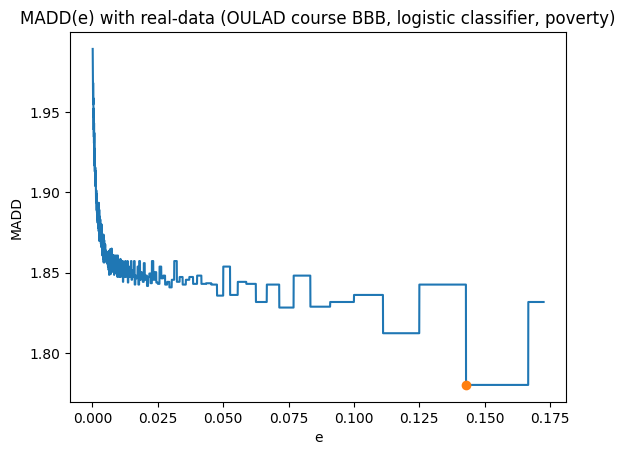

In [18]:
plt.plot(e, madd)
plt.plot(e[madd_min_ind], madd[madd_min_ind], "o", label="MADD minimum")
plt.xlabel("e")
plt.ylabel("MADD")
plt.title("MADD(e) with real-data (OULAD course BBB, logistic classifier, " + sensitive_feature + ")")

In [23]:
ind_cv = np.where(e< 0.02)[0][-1]

In [24]:
madd[ind_cv]

1.855929003021148